# TBD - Spark ML -loading data



## Wczytanie danych

Bedziemy wykorzystywać dane z ankiety StackOverflow z 2020.

https://insights.stackoverflow.com/survey/

Dane sa dostepne na google drive. Skorzystamy z modułu GoogleDriveDownloader, ktory pozwala pobrac dokument o podanym id.


In [ ]:
pip install googledrivedownloader

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

In [2]:
from pathlib import Path
path_dir = str(Path.home()) + "/data/2020/"  # ustawmy sciezke na HOME/data/2020
archive_dir = path_dir + "survey.zip"        # plik zapiszemy pod nazwa survey.zip

In [3]:
path_dir

'/home/jovyan/data/2020/'

In [4]:
archive_dir

'/home/jovyan/data/2020/survey.zip'

In [5]:
# sciagniecie pliku we wskazane miejsce
gdd.download_file_from_google_drive(file_id='1dfGerWeWkcyQ9GX9x20rdSGj7WtEpzBB',
                                    dest_path=archive_dir,
                                    unzip=True)

##  Podłączenie do sesji Spark


#### WAZNE
jesli w poprzednim notatniku masz aktywną sesję Spark zakończ ją (w poprzednim notatniku) poleceniem spark.stop()

In [7]:
from pyspark.sql import SparkSession
#spark.stop()
spark = SparkSession \
.builder \
.config("spark.executor.instances", "1")\
.config('spark.driver.memory','1g')\
.config('spark.executor.memory', '1g') \
.getOrCreate()

## Dostęp do danych

In [9]:
import os
user_name = 'jovyan'
print(user_name)

jovyan


In [49]:
# ścieżka dostępu do pliku
csv_path = 'file:////home/jovyan/data/2020/survey_results_public.csv'

In [11]:
csv_path

'file:////home/jovyan/data/2020/survey_results_public.csv'

## Spark SQL

Platforma Apache Spark posiada komponent Spark SQL, który pozwala traktować dane jak tabele w bazie danych. Można zakładać swoje schematy baz danych oraz korzystać z języka SQL.

In [12]:
table_name = "survey_2020"                               # nazwa tabeli ktora bedziemy chcieli stworzyc

In [17]:
spark.sql(f'DROP TABLE IF EXISTS {table_name}')       # usun te tabele jesli istniala wczesniej 

# stworz tabele korzystajac z danych we wskazanej lokalizacji
spark.sql(f'CREATE TABLE IF NOT EXISTS {table_name} \
          USING csv \
          OPTIONS (HEADER true, INFERSCHEMA true, NULLVALUE "NA") \
          LOCATION "{csv_path}"')

DataFrame[]

## Weryfikacja danych 
Sprawdzmy zaczytane dane.

In [19]:
spark.sql(f"describe {table_name}").show(100, truncate=False) # niepoprawne typy danych... "NA" 

+----------------------------+---------+-------+
|col_name                    |data_type|comment|
+----------------------------+---------+-------+
|Respondent                  |int      |null   |
|MainBranch                  |string   |null   |
|Hobbyist                    |string   |null   |
|Age                         |double   |null   |
|Age1stCode                  |string   |null   |
|CompFreq                    |string   |null   |
|CompTotal                   |double   |null   |
|ConvertedComp               |double   |null   |
|Country                     |string   |null   |
|CurrencyDesc                |string   |null   |
|CurrencySymbol              |string   |null   |
|DatabaseDesireNextYear      |string   |null   |
|DatabaseWorkedWith          |string   |null   |
|DevType                     |string   |null   |
|EdLevel                     |string   |null   |
|Employment                  |string   |null   |
|Ethnicity                   |string   |null   |
|Gender             

In [20]:
# sprawdzenie liczności tabeli
spark.sql(f"select count(*) from {table_name}").show()

+--------+
|count(1)|
+--------+
|   64461|
+--------+



## Podgląd danych

## Dataframe spark vs pandas

Moduł Pandas jest biblioteką Pythonową do manipulacji danymi. W szczegolnosci w pandas mozemy stworzyc ramki danych i wykonywac na niej analize, agregacje oraz wizualizacje danych. 
Przy nieduzych zbiorach danych i prostych operacjach to doskonała biblioteka. Jednak kiedy zbior danych sie rozrasta lub kiedy wymagane sa zlozone transformacje to operacje moga byc wolne.

Operacje na rozproszonych danych sa szybsze. Ale tu takze napotykamy ograniczenia np trudność w wizualizacji danych.

In [22]:
import pandas as pd

In [23]:
spark.sql(f"select * from {table_name} limit 10").toPandas()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,None,NaN,NaN,United Kingdom,Pound sterling,...,None,None,None,"Computer science, computer engineering, or sof...",None,None,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,None,NaN,NaN,Russian Federation,None,...,Neither easy nor difficult,Appropriate in length,None,None,None,None,Somewhat more welcome now than last year,NaN,4,None
3,4,I am a developer by profession,Yes,25.0,18,None,NaN,NaN,Albania,Albanian lek,...,None,None,No,"Computer science, computer engineering, or sof...",None,None,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,None,NaN,NaN,United States,None,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8
5,6,I am a developer by profession,No,NaN,14,None,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,None,None,React.js,None,None,NaN,6,4
6,7,I am a developer by profession,Yes,NaN,18,Monthly,NaN,NaN,India,United States dollar,...,None,None,None,"Computer science, computer engineering, or sof...",None,None,A lot more welcome now than last year,NaN,6,4
7,8,I am a developer by profession,Yes,36.0,12,Yearly,116000.0,116000.0,United States,United States dollar,...,Easy,Appropriate in length,No,"Computer science, computer engineering, or sof...",Django;React.js;Vue.js,Flask,Just as welcome now as I felt last year,39.0,17,13
8,9,I am a developer by profession,No,30.0,20,None,NaN,NaN,Tunisia,United States dollar,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",Angular.js,jQuery,Just as welcome now as I felt last year,50.0,6,4
9,10,I am a developer by profession,Yes,22.0,14,Yearly,25000.0,32315.0,United Kingdom,Pound sterling,...,Easy,Appropriate in length,No,Mathematics or statistics,Flask;jQuery,Flask;jQuery,Somewhat more welcome now than last year,36.0,8,4


**Ważne** 

Metoda toPandas() na ramce pyspark, konwertuje ramkę pyspark do ramki pandas. Wykonuje akcje pobrania (collect) wszystkich danych z executorów (z JVM) i transfer do  programu sterujacego (driver) i konwersje do typu Pythonowego w notatniku. Ze względu na ograniczenia pamięciowe w programie sterującym należy to wykonywać na podzbiorach danych.

**DataFrame.collect() collects the distributed data to the driver side as the local data in Python. Note that this can throw an out-of-memory error when the dataset is too large to fit in the driver side because it collects all the data from executors to the driver side.**

**Note that DataFrame.toPandas() results in the collection of all records in the DataFrame to the driver program and should be done on a small subset of the data.**

In [26]:
dist_df = spark.sql(f"select * from {table_name} LIMIT 10")
local_df = spark.sql(f"select * from {table_name} LIMIT 10").toPandas()

In [27]:
type(dist_df)  # dataframe Sparkowy ("przepis na dane, rozproszony, leniwy")

pyspark.sql.dataframe.DataFrame

In [28]:
type(local_df)  # dataframe Pandasowy (lokalny, sciągnięty do pamięci operacyjnej)

pandas.core.frame.DataFrame

In [30]:
#dist_df.show()

In [41]:
local_df

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,CurrencySymbol,DatabaseDesireNextYear,DatabaseWorkedWith,DevType,EdLevel,Employment,Ethnicity,Gender,JobFactors,JobSat,JobSeek,LanguageDesireNextYear,LanguageWorkedWith,MiscTechDesireNextYear,MiscTechWorkedWith,NEWCollabToolsDesireNextYear,NEWCollabToolsWorkedWith,NEWDevOps,NEWDevOpsImpt,NEWEdImpt,NEWJobHunt,NEWJobHuntResearch,NEWLearn,NEWOffTopic,NEWOnboardGood,NEWOtherComms,NEWOvertime,NEWPurchaseResearch,NEWPurpleLink,NEWSOSites,NEWStuck,OpSys,OrgSize,PlatformDesireNextYear,PlatformWorkedWith,PurchaseWhat,Sexuality,SOAccount,SOComm,SOPartFreq,SOVisitFreq,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,EUR,Microsoft SQL Server,Elasticsearch;Microsoft SQL Server;Oracle,"Developer, desktop or enterprise applications;...","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...",White or of European descent,Man,"Languages, frameworks, and other technologies ...",Slightly satisfied,I am not interested in new job opportunities,C#;HTML/CSS;JavaScript,C#;HTML/CSS;JavaScript,.NET Core;Xamarin,.NET;.NET Core,Microsoft Teams;Microsoft Azure;Trello,Confluence;Jira;Slack;Microsoft Azure;Trello,No,Somewhat important,Fairly important,None,None,Once a year,Not sure,None,No,Often: 1-2 days per week or more,Start a free trial;Ask developers I know/work ...,Amused,Stack Overflow (public Q&A for anyone who codes),Visit Stack Overflow;Go for a walk or other ph...,Windows,2 to 9 employees,Android;iOS;Kubernetes;Microsoft Azure;Windows,Windows,None,Straight / Heterosexual,No,"No, not at all",None,Multiple times per day,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,None,NaN,NaN,United Kingdom,Pound sterling,GBP,None,None,"Developer, full-stack;Developer, mobile","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,None,None,None,Very dissatisfied,I am not interested in new job opportunities,Python;Swift,JavaScript;Swift,React Native;TensorFlow;Unity 3D,React Native,Github;Slack,Confluence;Jira;Github;Gitlab;Slack,None,None,Fairly important,None,None,Once a year,Not sure,None,No,None,None,Amused,Stack Overflow (public Q&A for anyone who code...,Visit Stack Overflow;Go for a walk or other ph...,MacOS,"1,000 to 4,999 employees",iOS;Kubernetes;Linux;MacOS,iOS,I have little or no influence,None,Yes,"Yes, definitely",Less than once per month or monthly,Multiple times per day,None,None,None,"Computer science, computer engineering, or sof...",None,None,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,None,NaN,NaN,Russian Federation,None,None,None,None,None,None,None,None,None,None,None,None,Objective-C;Python;Swift,Objective-C;Python;Swift,None,None,None,None,None,None,None,None,None,Once a decade,None,None,No,None,None,None,Stack Overflow (public Q&A for anyone who codes),None,Linux-based,None,None,None,None,None,Yes,"Yes, somewhat",A few times per month or weekly,Daily or almost daily,Neither easy nor difficult,Appropriate in length,None,None,None,None,Somewhat more welcome now than last year,NaN,4,None
3,4,I am a developer by profession,Yes,25.0,18,None,NaN,NaN,Albania,Albanian lek,ALL,None,None,None,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",None,White or of European descent,Man,Flex time or a flexible schedule;Office enviro...,Slightly dissatisfied,"I’m not actively looking, but I am open to new...",None,None,None,None,None,None,No,None,Not at all important/not necessary,Curious about other opportunities;Wanting to w...,None,Once a year,Not sure,Yes,Yes,Occasionally: 1-2 days per quarter but l

In [40]:
pd.set_option('display.max_columns', None)    # pokazuj wszystkie kolumny
#pd.reset_option('max_columns')

## Przykład wykorzystania Spark'a do wizualizacji
### Narysuj histogram wieku respondentów

In [44]:
# przygotowanie danych
# przycinamy dane tylko do zakresu ktory jest potrzebny do realizacji polecenia
ages = spark.sql(f"SELECT CAST (Age AS INT) \
                    FROM {table_name} \
                    WHERE age IS NOT NULL \
                    AND age BETWEEN 10 AND 80").toPandas()

In [45]:
ages

,Age
0,25
1,31
2,36
3,30
4,22
...,...
45403,22
45404,34
45405,38
45406,64


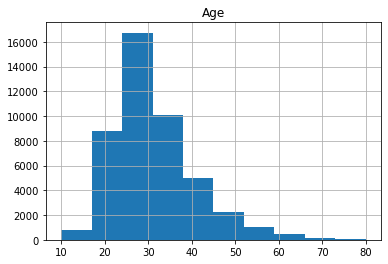

In [46]:
ages.hist("Age", bins=10)
plt.show()

In [48]:
spark.stop()